# Introduction

* Hello, our names are Geary and Shorter
* This is our project detailing the process undertaken to predict the log error contained within the 2017 Zillow dataset

## Project Objective 
> Document code, process data (through entire pipeline), and articulate key findings and takeways
* Create modules that faciliate project repeatability, as well as final report readability
> Ask/Answer exploratory questions of data and attributes to understand drivers of home value  
* Utilize charts and statistical tests
> Construct models to predict logerror for single family properties using regression techniques</br>  
> Make recommendations

## Project Business Goals
> Construct ML Regression model that accurately predicts `logerror`of *Single Family Properties*
* `logerror` = log(Zestimate) - log(SalePrice))</br>
> Find key drivers of `logerror`</br>
> Deliver report that the data science team can read through and replicate  
> Share steps were taken, why and what the outcome was.
> Make recommendations on what works or doesn't work in predicting `logerror`

### Executive Summary
* Relied on clustering for bulk of feature differientation to predict `logerror`
* Feature sets informed by clustering performed best on model through validation phase
* Model gain on predictive performance vs. baseline prediction was minimal on test set

# Import Section

In [1]:
#### Import Section
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import wrangle_zillow
import explore_zillow
import model

from itertools import product
from scipy.stats import levene , pearsonr, spearmanr, mannwhitneyu, f_oneway, ttest_ind
from sklearn.metrics import mean_squared_error, explained_variance_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, TweedieRegressor, LassoLars
from sklearn.preprocessing import PolynomialFeatures
from sklearn.feature_selection import RFE, f_regression, SelectKBest

import warnings
warnings.filterwarnings("ignore")


## Wrangle (Acquire and Prep)
> Look for csv, 
- If no sql query a custom search, 
- Otherwise, use csv  
> Returns a dataframe that is then cleaned: 
- Replacing NaNs with 0 or None where applicable depending on feature type  
- Drop Columns and Rows where majority still have NaNs
- Dropped extraneous columns that provided no value during after initial explore/model phases
* Feature Engineering
> Features:
- `openness`: Area / (Bedrooms + Bathrooms): Relative size  
- `age`: Years since House Built  
- `tax_per_sqft`: Home Value / Sqft: Relative value  
- `home_size`: Binned Category of Area  
- `est_tax_rate`: Estimated Tax Rate of County  
> Clusters:
- `house_tax` :|: [tax_per_sqft, est_tax_rate, openness]  
- `house_details` :|: [lotsizesquarefeet, garagetotalsqft, poolcnt]  
- `house_sizing` :|: [area, bathrooms, bedrooms]  
- `house_locale` :|: [latitude, longitude ,age]  
> Split:  
- Train: 54%  
- Validate: 24%  
- Test: 20%  
> Scaled:  
- MinMaxScaler(): Used for cluster engineering and modeling  
> Summary  
- Visualized distinctions within the data to inform exploratory analysis  
    

In [2]:
#calling prepare/acquire functions from module to acruire data subsets
df, train, validate, test, train_scaled, validate_scaled, test_scaled = wrangle_zillow.wrangle_zillow()


(28971, 22) (12417, 22) (10348, 22)
-----
DataFrame info:

<class 'pandas.core.frame.DataFrame'>
Int64Index: 51736 entries, 1727539 to 1187175
Data columns (total 22 columns):
 #   Column                      Non-Null Count  Dtype   
---  ------                      --------------  -----   
 0   basementsqft                51736 non-null  float64 
 1   bathrooms                   51736 non-null  float64 
 2   bedrooms                    51736 non-null  float64 
 3   area                        51736 non-null  float64 
 4   county                      51736 non-null  object  
 5   garagecarcnt                51736 non-null  float64 
 6   garagetotalsqft             51736 non-null  float64 
 7   latitude                    51736 non-null  float64 
 8   longitude                   51736 non-null  float64 
 9   lotsizesquarefeet           51736 non-null  float64 
 10  poolcnt                     51736 non-null  float64 
 11  structuretaxvaluedollarcnt  51736 non-null  float64 
 12  home_va

## Exploration Questions 
* Includes visualizations and statistical tests

### Guidance - Initial Questions
* Heatmap to help direct initial questions, and visualize linear correlation possibilities
* Logerror (target feature) highlighted in red for legibility

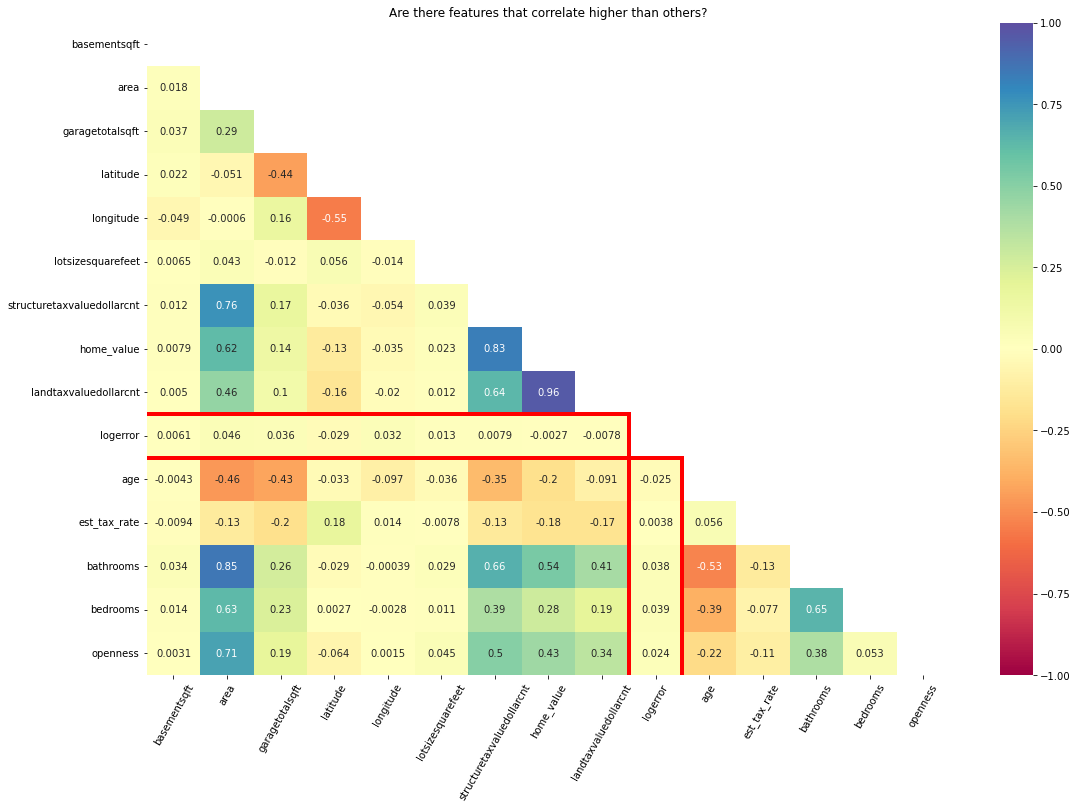

In [3]:
# calls function to generate heatmap of continous variables within training subset
explore_zillow.explore_inital_guidance(train)

#### Takeaways
* No strong relationships are sticking out, Area being the strongest candidate for later use
* Incorporated informaton gleaned into cluster creation and feature selection 

### Question 1 -  Do `logerror` and Area(sqft) have any correlation
> ${H_0}$: There is not a correlation in `logerror` and `area`   
> ${H_a}$: There is a correlation in `logerror` and `area`   
> ${\alpha}$: .05

> Result: There is enough evidence to reject our null hypothesis.
> **Test code below**: Runs Spearman r corrlation test to support/reject hypothesis

Results of SpearmanR (r = 0.081|p = 0.0)


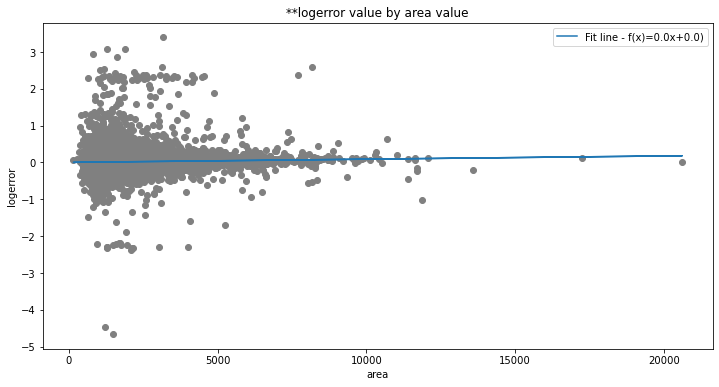

In [4]:
## assigns two variables to be used in the scatterplot, which has a polyline(1) plotted over it,
## Also runs a SpearmanR correlation test and returns the values

#set variables
col1,target = "area", "logerror"
x,y = train[col1], train[target]

#test and results
r, p = spearmanr(x,y)
print(f"Results of SpearmanR (r = {round(r,3)}|p = {round(p,3)})")

#plot
plt.figure(figsize=(12, 6))
plt.plot(x, y, "o",color="grey")
m,b = np.polyfit(x,y,1)
plt.plot(x,m*x+b,label=f"Fit line - f(x)={round(m,3)}x+{round(b,0)})")
plt.xlabel(col1), plt.ylabel(target)
plt.legend(), plt.title(f"**{target} value by {col1} value")
plt.show()

> #### Q1 takeway:
- Due to having a p value less than our alpha we were able to determine that there is correlation that we can utilize in our modeling however it very weak
- Use results of test fo formulate basis for creating Clusters based on house sizing that included : `area`, `bathrooms`, and `bedrooms`

### Question 2 - Is there a difference in log error between the different types of heating?


In [5]:
# groups train dataset by heating types and ranks them by mean logerror
train.groupby(["heating"])["logerror"].agg("mean").sort_values(ascending=False)

heating
None          0.027749
Other         0.016589
Floor/Wall    0.015347
Central       0.015080
Name: logerror, dtype: float64

#### Takeaway
* Homes with None as heating type appear to have a higher log error mean

#### Statistical Testing
${H_0}$: There is no significant difference in mean `logerror` between properties with `no_heating` and the wider population  
${H_a}$: There is significant difference in mean `logerror` between properties with `no_heating` and the wider population    
${\alpha}$: .05

> Result: There is enough evidence to reject our null hypothesis.   
> **Test code below**: function in module does a 1 sample TTest against the population


 We reject the null Hypothesis ( N̶o̶n̶e̶ ̶a̶s̶ ̶a̶ ̶s̶a̶m̶p̶l̶e̶ ̶h̶a̶s̶ ̶e̶q̶u̶a̶l̶ ̶m̶e̶a̶n̶ ̶v̶a̶l̶u̶e̶s̶ ̶t̶o̶ ̶h̶e̶a̶t̶i̶n̶g̶ ̶a̶s̶ ̶a̶ ̶p̶o̶p̶u̶l̶a̶t̶i̶o̶n̶ ̶r̶e̶g̶a̶r̶d̶i̶n̶g̶ ̶l̶o̶g̶e̶r̶r̶o̶r̶ ) t=4.02012, p=0.00006


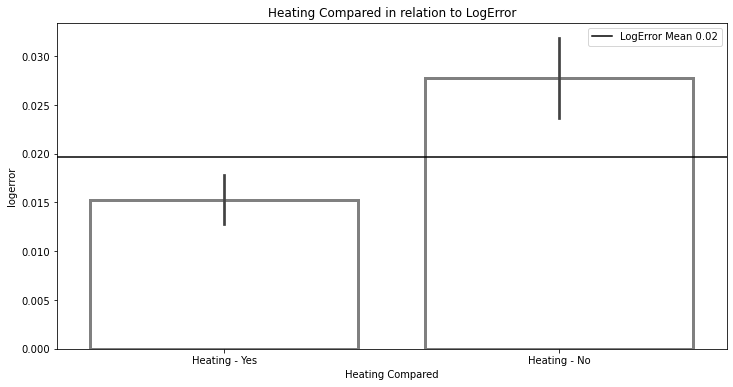

In [6]:
## function in module does a 1 sample TTest against the population and 
## returns the result for Heating(None), plots the feature as sampled
explore_zillow.explore_heating(train)

> #### Q2 takeway:
- Whether you have heating, or not, does significantly affect LogError, and as such should be considered in Modeling for prediction
- Added consideration of heating capability to feature selection phase of Modeling

## Guidance - Clusters
Run statistical tests and visualizations on the clusters to verify if the results of our clustering are signifcant

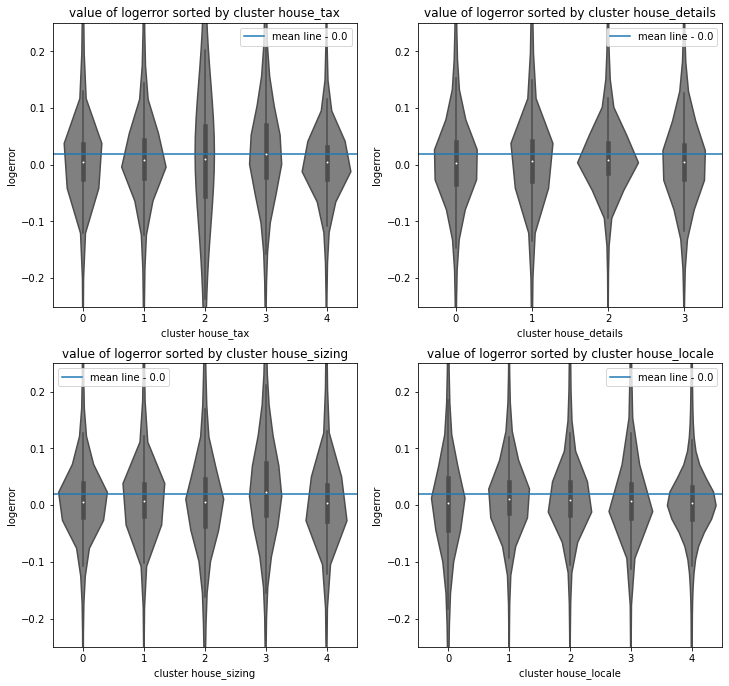

,variable,p_val
13,cluster house_sizing(3),4.473734e-09
14,cluster house_locale(0),6.784459e-07
2,cluster house_tax(4),1.017880e-06
15,cluster house_locale(1),2.319610e-06
8,cluster house_details(2),7.431146e-05


In [7]:
## function in module does a 1 sample TTest against the population for each cluster
## returns the result
explore_zillow.viz_clusters(train,"logerror")
explore_zillow.score_clusters(train,"logerror")[["variable","p_val"]].sort_values(by=["p_val"]).head(5)

### Takeaway
* We have p values low enough to verify that there may be relationships to investigate
* The Housing Tax cluster 4 shows great variation in log error

## Question 3 -  Does the Home Size clustering reveal any signifcant log error differences?

In [8]:
# groups train dataset by home size clustering and ranks them by mean logerror
train.groupby(["cluster house_sizing"])["logerror"].agg("mean").sort_values(ascending=False)

cluster house_sizing
3    0.050005
1    0.022722
2    0.014542
4    0.014437
0    0.014122
Name: logerror, dtype: float64

#### Statistical Testing
${H_0}$: There is no significant difference in mean LogError of the sample Home Size (Cluster 3) compared to the population  
${H_a}$: There is significant difference in mean LogError of the sample Home Size (Cluster 3) compared to the population  
${\alpha}$: .05

> Result: There is enough evidence to reject our null hypothesis.  
> **Test code below**: function runs a tailored ttest and plots the feature for this question


 We reject the null Hypothesis ( 3̶ ̶a̶s̶ ̶a̶ ̶s̶a̶m̶p̶l̶e̶ ̶h̶a̶s̶ ̶e̶q̶u̶a̶l̶ ̶a̶v̶e̶r̶a̶g̶e̶ ̶v̶a̶l̶u̶e̶s̶ ̶t̶o̶ ̶c̶l̶u̶s̶t̶e̶r̶ ̶h̶o̶u̶s̶e̶_̶s̶i̶z̶i̶n̶g̶ ̶a̶s̶ ̶a̶ ̶p̶o̶p̶u̶l̶a̶t̶i̶o̶n̶ ̶r̶e̶g̶a̶r̶d̶i̶n̶g̶ ̶l̶o̶g̶e̶r̶r̶o̶r̶ ) t=5.88908, p=0.00000


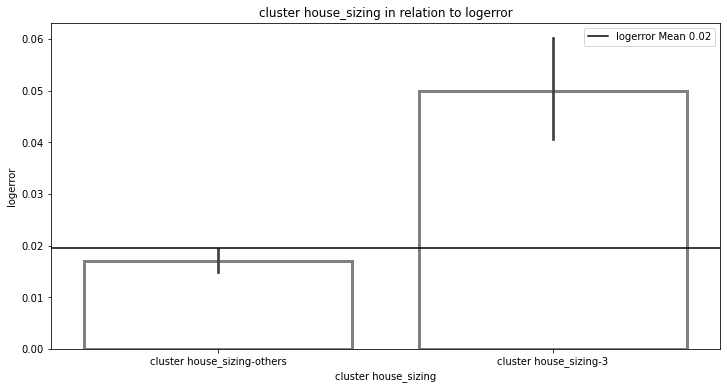

In [9]:
## function tailored for this question. does a sample ttest and returns results with a plot of the feature
explore_zillow.explore_ttest_cluster(train,"cluster house_sizing")

> #### Q3 takeway:
- The amount of area(sqft), bedrooms, and bathrooms play a role in the ability to predict logerror, with our Cluster 3 being divergent compared to the population
- Used information to ensure house size clusters were included in feature consideration

### Question 4 -  Does Locale clustering reveal any differences between the clusters?

In [10]:
# groups train dataset by house locale clustering and ranks them by mean logerror
train.groupby(["cluster house_locale"])["logerror"].agg("mean").sort_values(ascending=False)

cluster house_locale
1    0.033736
3    0.023656
2    0.017968
4    0.016535
0    0.008354
Name: logerror, dtype: float64

${H_0}$: There is no significant difference in mean LogError of the sample House Locale (Cluster 0) compared to the population  
${H_a}$: There is significant difference in mean LogError of the sample House Locale (Cluster 0) compared to the population  
${\alpha}$: .05

> Result: There is enough evidence to reject our null hypothesis.  
> **Test code below**: function runs a two-tail t-test and plots the feature


 We reject the null Hypothesis ( 0̶ ̶a̶s̶ ̶a̶ ̶s̶a̶m̶p̶l̶e̶ ̶h̶a̶s̶ ̶e̶q̶u̶a̶l̶ ̶a̶v̶e̶r̶a̶g̶e̶ ̶v̶a̶l̶u̶e̶s̶ ̶t̶o̶ ̶c̶l̶u̶s̶t̶e̶r̶ ̶h̶o̶u̶s̶e̶_̶l̶o̶c̶a̶l̶e̶ ̶a̶s̶ ̶a̶ ̶p̶o̶p̶u̶l̶a̶t̶i̶o̶n̶ ̶r̶e̶g̶a̶r̶d̶i̶n̶g̶ ̶l̶o̶g̶e̶r̶r̶o̶r̶ ) t=-4.97150, p=0.00000


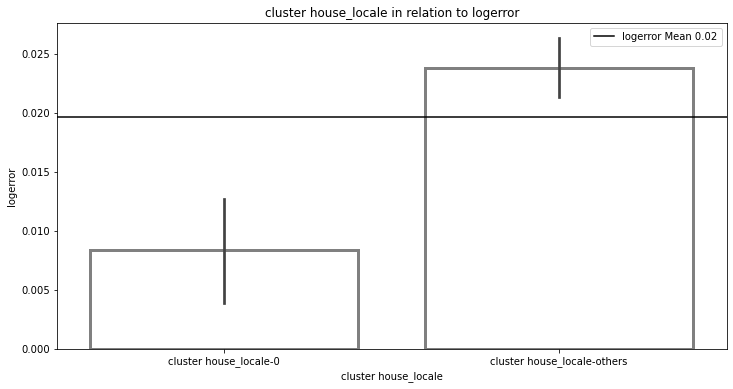

In [11]:
## function tailored for this question. does a sample ttest and returns results with a plot of the feature
explore_zillow.explore_ttest_cluster(train,"cluster house_locale")

> #### Q4 takeway:
* The amount of location (lat and long), and age play a role in the ability to predict logerror, with our Cluster 0 being divergent compared to the population
* Testing confirms a significantly lower mean logerror in homes within Cluster 0

## Overall Exploration Takeaways
* Not many very large drivers of logerror. 
* Area showed highest correlation, later verified as meaningful, of .046. Exists, but weak. 
* Clustering based on Locale and Home size showed statistically verified difference. Will use in model feature selection
* A combination of features and clusters will likely give us the best result to predict log error
    * Will look at blending features used to create the different clusters with clusters based on non-utilized features

# Modeling

In [12]:
#call modeling preparation function to acquire train/validate/test subsets
X_train, y_train, X_val, y_val, X_test, y_test = model.modeling_prep(train, train_scaled, validate, validate_scaled, test, test_scaled)

In [13]:
#model and score various functions and find list of best four performing
train_scores = model.score_on_train(X_train, y_train)

#prints out list of features generated by selectKbest and regression feature engineering (RFE) functions

In [14]:
#model and score various functions and find list of best four performing on the train set
top_four = train_scores.sort_values(by='RMSE').head(4)

In [15]:
top_four[['Name', 'RMSE']]

,Name,RMSE
1,Polynomial_1,0.185110
3,Polynomial_3,0.185343
2,Polynomial_2,0.185467
11,LARS_1,0.185889


## Validation Scoring - Top 4

In [16]:
validate_scores, y_val = model.score_on_validate(train_scores, X_val, y_val, X_train, y_train)

In [17]:
validate_scores[['Name', 'RMSE']].sort_values(by='RMSE').head(4)

,Name,RMSE
11,LARS_1,0.165662
6,OLS_1,0.165662
22,GLM_2,0.165662
31,GLM_11,0.165667


* Lars 1
    - Type: LassorLars
    - Alpha: 0
    - Features: House Tax/Locale/Sizing Clusters, `area`, `poolcnt_1.0`, `home_value`, `county_Orange County`, `county_Ventura County`
* OLS 1
    - Type: LassorLars
    - Alpha: 3
    - Features: House Tax/Locale/Sizing Clusters, `area`, `poolcnt_1.0`, `home_value`, `county_Orange County`, `county_Ventura County` 
* GLM 2
    - Type: LassorLars
    - Power: 0
    - Alpha: 0.25
    - Features: House Tax/Locale/Sizing Clusters, `area`, `poolcnt_1.0`, `home_value`, `county_Orange County`, `county_Ventura County` 
* GLM 11
    - Type: LassorLars
    - Alpha: 3
    - Features: House Sizing/Locale Clusters, `home_value`, `county_Orange County`, `county_Ventura County`  

### Takeaways
* During initial testing a lot of overfitting happening when using all features
* `locale_feat` is set of features focusing on the clusters created using location based selection
* further bolstered feature sets by including features taken from models that did not perform as well, but were not at the bottom of the pack
-----------
* After continued testing the polynomial perform worse with the more robust feature sets. highly suggestive of overfitting. Will be eliminating those of degree 3 or more from further experimentation. 
* LARS models appear to be similarly unproductive
-----------
* for next round of mass model testing will add further blends that are inclusive of the tax, sizing, and locale clusters
-----------
* Models primarily compared via RMSE score and dropped out of contention for successive modelling passes
* GLM and OLS models grew in performance with additional feature selection incorporating clustering
-----------
* LARS models showed massive gains in fourth round of large scale model testing on train set
* Applying different feature combinations along with an alpha of 0, but it just did beat out the OLS model using the same code


## Test
* Best Performing Model:
    - Lars_1: LassoLars 
    - Alpha: 0
    - Features: House Tax/Locale/Sizing Clusters, `area`, `poolcnt_1.0`, `home_value`, `county_Orange County`, `county_Ventura County`

In [18]:
#calls function from  model module to fit and test the best perfoming model on the test subset 
model.score_on_test(X_test, y_test, X_train, y_train)[['Name', 'RMSE']]

,Name,RMSE
0,pred_median,0.153141
1,LARS_1,0.152985


# Conclusion

## Summary of Key Findings
* Low correlation values among all features with `logerror` led to relying on clustering for bulk of feature differientation
* Clustering creation was able to show difference in log error prediction
* Feature sets informed by clustering performed best on model through validation phase
    * Best model utilized Clustering based tax information, size, and locale
* Model gain on predictive performance vs. baseline prediction was minimal on test set
    * Baseline RMSE: 0.1531
    * Model RMSE: .1529 (Lower is better) 

## Suggestions and Next Steps
* No suggestions this time as the model barely beats baseline predictions
* Take a look at adding distance relationships
    - Distance from: water, schools, parks, etc. 
* Investigate walk/bike/transit scores
* Possible look at reducing variation within features by analyzing significance
    - Identify features were log error variation was driven by primarly outliers 
* May consider creating county and cluster specific models
* Take different approach to null/missing data
    - Rely more on imputation involving population data, as opposed to NA/Null = None/0 decision